In [1]:
import os
import re
import glob
import yaml
import warnings
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker

from scipy.stats import pearsonr
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl
pl.seed_everything(42)

from dataset import E33OMA, E33OMA90D
from model import STMLightning
from utils import qqplot, find_nearest

import geopandas as gpd
from cartopy import crs as ccrs
import cartopy.mpl.ticker as cticker

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Load the world shapefile provided by geopandas
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

Seed set to 42
/home/serfani/miniforge3/envs/Lightning/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def natural_sort_key(s):
    # Split the string into segments of digits and non-digits
    return [int(text) if text.isdigit() else text.lower() for text in re.split('(\d+)', s)]

models_path_root = '/home/serfani/serfani_data1/snapshots'
# List directory contents
dir_contents = os.listdir(models_path_root)

# Sort using the custom sort key
sorted_contents = sorted(dir_contents, key=natural_sort_key)

# Print sorted contents
for idx, model in enumerate(sorted_contents):
    print(idx, model)

0 Conv3D-03122025-1601
1 Conv3D-03122025-1651
2 Conv3D-03142025-1002
3 Conv3D-03192025-1113
4 ConvLSTM-02102025-1714
5 ConvLSTM-03122025-1209
6 ConvLSTM-03122025-1308
7 ConvLSTM-03242025-1200
8 ConvLSTM-04152025-1359
9 ConvLSTM-04292025-1357
10 LSTM-64K5.32K3.16K3-E33OMA90D-5C-BCB-20241014-1247
11 LSTM-64K5.32K3.16K3-E33OMA-5C-BCB-20240723-0949
12 LSTM-64K5.32K3.16K3-E33OMA-8C-BCB-20240719-1241
13 SimVP-02132025-1532
14 UNet-E33OMA-5C-BCB-20240718-1527


In [3]:
model_index_list = [1, 7, 13]
model_results = {}
save_figure = True

for idx, model_index in enumerate(model_index_list):
    model_name  = sorted_contents[model_index]

    # Read the YAML files
    snapshot_dir = os.path.join(models_path_root, model_name)

    with open(os.path.join(snapshot_dir, 'test-results.npy'), mode='rb') as f:
        GTs = np.load(f, allow_pickle=True)
        PDs = np.load(f, allow_pickle=True)
        
        if idx == 0:
            model_results['GTs'] = GTs
            model_results[model_name.split('-')[0]] = PDs
        else:
            model_results[model_name.split('-')[0]] = PDs

print(model_results.keys())


dict_keys(['GTs', 'Conv3D', 'ConvLSTM', 'SimVP'])


In [4]:
for root, dirs, files in os.walk('/home/serfani/serfani_data1/E33OMA'):
    
    sorted_files = sorted(files)
    list4 = [os.path.join(root, file) for file in sorted_files if file.split(".")[1] == 'tNDaijh1E33oma_ai'] # Clay-BCB Src (time, lat, lon)

ds4  = xr.open_mfdataset(list4[365:])

### Load Dataset and Model

In [5]:
dataset = E33OMA(period='test', species='bcb', padding=[5, 5], sequence_length=48)

In [6]:
path = '/home/serfani/serfani_data1/E33OMA/ANN1951.xaijE33oma_ai.nc'
ds_annual = xr.open_dataset(path, decode_times=False)

prsurf = ds_annual['prsurf'].values * 100 # Convert pressure from hectopascals (hPa) to pascals (Pa).
tsavg = ds_annual['tsavg'].values + 273.15 # Convert temperature from Kelvin to Celsius.

R_d = 287.055 # Specific gas constant for dry air in J/(kg·K)
rho = prsurf / (R_d * tsavg) # Calculate air density in kg/m^3

for key, value in model_results.items():
    model_results[key] = value * 0.01 * rho # Convert from mixing ratio (kg/kg_air x 10^-11) to micrograms per cubic meter (μg/m^3)

In [7]:
def r_squared_temporal(gts, pds):

    r_squared_temporal = np.empty((gts.shape[0]))
    pearsonr_temporal = np.empty((gts.shape[0]))
    mae_temporal = np.empty((gts.shape[0]))
    rmse_temporal = np.empty((gts.shape[0]))

    for i, gt in enumerate(gts):
        r_squared_temporal[i] = r2_score(gt.flatten(), pds[i].flatten())
        pearsonr_temporal[i], _ = pearsonr(gt.flatten(), pds[i].flatten())
        mae_temporal[i] = mean_absolute_error(gt.flatten(), pds[i].flatten())
        rmse_temporal[i] = np.sqrt(root_mean_squared_error(gt.flatten(), pds[i].flatten()))

    return pd.DataFrame({
        'r_squared': r_squared_temporal,
        'pearsonr': pearsonr_temporal,
        'mae': mae_temporal,
        'rmse': rmse_temporal
    })

In [8]:
temporal_resluts = {}

for key, value in model_results.items():
    if key == 'GTs':
        continue
    temporal_resluts[key] = r_squared_temporal(model_results['GTs'], value)

In [12]:
# month_to_season = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 
#                    7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'}

month_to_period = {
    12: 'DJF', 1: 'DJF', 2: 'DJF',
    3: 'MAM', 4: 'MAM', 5: 'MAM',
    6: 'JJA', 7: 'JJA', 8: 'JJA',
    9: 'SON', 10: 'SON', 11: 'SON'
}

temporal_resluts['Conv3D'].loc[:, 'time'] = dataset.datetimeindex
temporal_resluts['ConvLSTM'].loc[:, 'time'] = dataset.datetimeindex
temporal_resluts['SimVP'].loc[:, 'time'] = dataset.datetimeindex

temporal_resluts['Conv3D'].loc[:, 'season'] = dataset.datetimeindex.month.map(month_to_period)
temporal_resluts['ConvLSTM'].loc[:, 'season'] = dataset.datetimeindex.month.map(month_to_period)
temporal_resluts['SimVP'].loc[:, 'season'] = dataset.datetimeindex.month.map(month_to_period)

In [13]:
temporal_resluts['Conv3D'].groupby('season').get_group('DJF')

,r_squared,pearsonr,mae,rmse,time,season
0,0.987620,0.994310,0.008559,0.216138,1951-01-01 23:45:00,DJF
1,0.984898,0.992866,0.009068,0.228332,1951-01-02 00:15:00,DJF
2,0.981382,0.991154,0.009537,0.241486,1951-01-02 00:45:00,DJF
3,0.976982,0.989132,0.010073,0.255108,1951-01-02 01:15:00,DJF
4,0.973257,0.987338,0.010439,0.264957,1951-01-02 01:45:00,DJF
...,...,...,...,...,...,...
17468,0.865969,0.949539,0.011443,0.255135,1951-12-31 21:45:00,DJF
17469,0.874123,0.952060,0.011497,0.255969,1951-12-31 22:15:00,DJF
17470,0.879967,0.952667,0.011592,0.257197,1951-12-31 22:45:00,DJF
17471,0.886010,0.952867,0.011635,0.257648,1951-12-31 23:15:00,DJF


In [14]:
conv3d_winter = temporal_resluts['Conv3D'].groupby('season').get_group('DJF')['r_squared']
conv3d_spring = temporal_resluts['Conv3D'].groupby('season').get_group('MAM')['r_squared']
conv3d_summer = temporal_resluts['Conv3D'].groupby('season').get_group('JJA')['r_squared']
conv3d_autumn = temporal_resluts['Conv3D'].groupby('season').get_group('SON')['r_squared']

convlstm_winter = temporal_resluts['ConvLSTM'].groupby('season').get_group('DJF')['r_squared']
convlstm_spring = temporal_resluts['ConvLSTM'].groupby('season').get_group('MAM')['r_squared']
convlstm_summer = temporal_resluts['ConvLSTM'].groupby('season').get_group('JJA')['r_squared']
convlstm_autumn = temporal_resluts['ConvLSTM'].groupby('season').get_group('SON')['r_squared']

simvp_winter = temporal_resluts['SimVP'].groupby('season').get_group('DJF')['r_squared']
simvp_spring = temporal_resluts['SimVP'].groupby('season').get_group('MAM')['r_squared']
simvp_summer = temporal_resluts['SimVP'].groupby('season').get_group('JJA')['r_squared']
simvp_autumn = temporal_resluts['SimVP'].groupby('season').get_group('SON')['r_squared']

cov3d = [conv3d_winter, conv3d_spring, conv3d_summer, conv3d_autumn]
covlstm = [convlstm_winter, convlstm_spring, convlstm_summer, convlstm_autumn]
simvp = [simvp_winter, simvp_spring, simvp_summer, simvp_autumn]

ticks = ['DJF', 'MAM', 'JJA', 'SON']

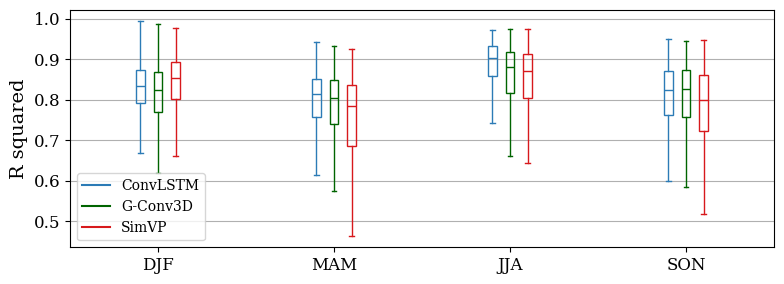

In [15]:
def set_box_color(bp, edge_color, fill_color='none'):
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
        
    return bp

def plot_boxplot(ax, m1, m2, m3, ticks):
    
    ml  = ax.boxplot(m1, positions=np.array(np.arange(len(m1)))*2.0-0.2, sym='', widths=0.1, patch_artist=True)
    mm = ax.boxplot(m2, positions=np.array(np.arange(len(m2)))*2.0+0.0, sym='', widths=0.1, patch_artist=True)
    mr = ax.boxplot(m3, positions=np.array(np.arange(len(m3)))*2.0+0.2, sym='', widths=0.1, patch_artist=True)

    set_box_color(ml, '#2C7BB6')  # Winter
    set_box_color(mm, '#006400')  # Spring
    set_box_color(mr, '#D7191C')  # Summer


    # draw temporary red and blue lines and use them to create a legend
    ax.plot([], c='#2C7BB6', label=r'ConvLSTM')
    ax.plot([], c='#006400', label=r'G-Conv3D') # green color code is #2C7BB6
    ax.plot([], c='#D7191C', label=r'SimVP')
    ax.legend(fontsize=10, loc=3)

    ax.set_xticks(np.arange(0, len(ticks) * 2, 2))
    ax.set_xticklabels(ticks)
    ax.set_xlim(-1, len(ticks)*2-1)

    ax.grid(axis='y')

# Define Font style
plt.rcParams.update({'font.family': 'serif'})

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 3))

plot_boxplot(axs, covlstm, cov3d, simvp, ticks)

axs.set_ylabel(r'R squared', fontsize=14)
# Adjust layout to prevent clipping of the legend
plt.tight_layout()

plt.show()

In [16]:
# Define the r_squared_spatial function
def r_squared_spatial(real_data, model_output):
    # Calculate the coefficient of determination (R^2)
    ss_res = np.sum((real_data - model_output) ** 2, axis=0)
    ss_tot = np.sum((real_data - np.mean(real_data, axis=0)) ** 2, axis=0)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

In [17]:
spatial_results = {}
for key, value in model_results.items():
    if key == 'GTs':
        continue
    spatial_results[key] = r_squared_spatial(model_results['GTs'], value)

In [18]:
ds = xr.Dataset({
    'Real Data': (["time", "lat", "lon"], model_results["GTs"].squeeze()),
    'Model Output': (["model", "time", "lat", "lon"], np.stack([model_results["ConvLSTM"].squeeze(), model_results["Conv3D"].squeeze(), model_results["SimVP"].squeeze()], axis=0)),
    'Coefficient of Determination': (["model", "lat", "lon"], np.stack([spatial_results["ConvLSTM"].squeeze(), spatial_results["Conv3D"].squeeze(), spatial_results["SimVP"].squeeze()], axis=0)),

              },
              
     coords=dict(
        model = ['ConvLSTM', 'G-Conv3D', 'SimVP'],
        time = dataset.datetimeindex,
        lon  = dataset.lon,
        lat  = dataset.lat,
    )
)

ds

<xarray.Dataset> Size: 4GB
Dimensions:                       (time: 17473, lat: 90, lon: 144, model: 3)
Coordinates:
  * model                         (model) <U8 96B 'ConvLSTM' 'G-Conv3D' 'SimVP'
  * time                          (time) datetime64[ns] 140kB 1951-01-01T23:4...
  * lon                           (lon) float32 576B -178.8 -176.2 ... 178.8
  * lat                           (lat) float32 360B -90.0 -87.0 ... 87.0 90.0
Data variables:
    Real Data                     (time, lat, lon) float32 906MB 0.0001242 .....
    Model Output                  (model, time, lat, lon) float32 3GB 0.00023...
    Coefficient of Determination  (model, lat, lon) float32 156kB -0.2374 ......

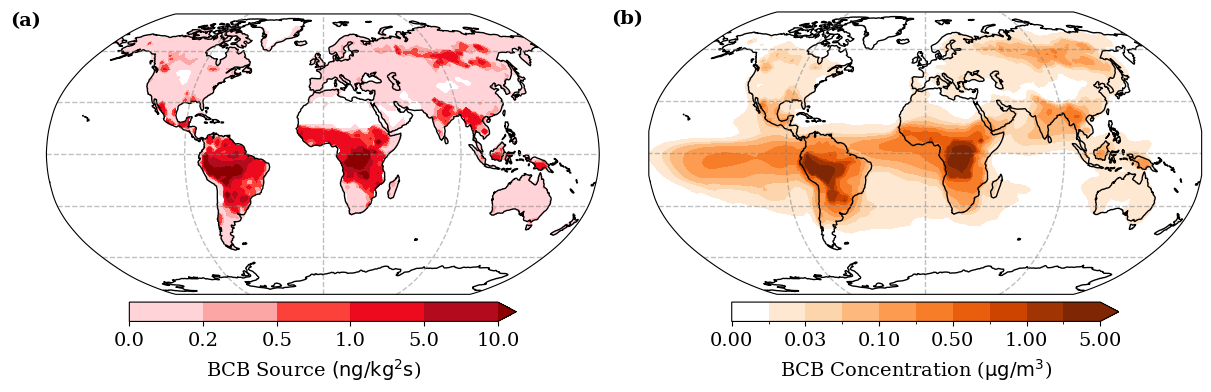

In [20]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12, 4), subplot_kw={'projection': ccrs.Robinson()}, constrained_layout=True)

# Create a meshgrid for longitude and latitude
lon, lat = np.meshgrid(ds4['lon'], ds4['lat'])

data1 = ds4['BCB_biomass_src'].mean(dim='time')
data1 = np.where(data1 <= 0.0, np.nan, data1)

ax1.coastlines()

colors = [(0.0, 'mistyrose'), (0.025, 'pink'), (0.05, 'salmon'), (0.1, 'red'), (0.5, 'crimson'), (1.0, 'darkred')]
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

im1 = ax1.contourf(
    lon, lat, data1,
    transform=ccrs.PlateCarree(),
    levels=[0, 0.25, 0.5, 1.0, 5.0, 10], 
    cmap=cmap, extend='max'
)

gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl1.xlocator = mticker.FixedLocator([-180, -90, 0, 90, 180])
gl1.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60])


# Add an individual colorbar for each subplot
cbar1 = plt.colorbar(im1, ax=ax1, orientation='horizontal', pad=0.02, shrink=0.7)
# cbar1.set_label(r'BCB Source $\times 10^{-12} (\mathrm{kg} / \mathrm{kg}^{2} \mathrm{s}$)', rotation=0, labelpad=5, fontsize=14)
cbar1.set_label(r'BCB Source $(\mathrm{ng} / \mathrm{kg}^{2} \mathrm{s}$)', rotation=0, labelpad=5, fontsize=14)

cbar1.ax.tick_params(labelsize=14)  # Adjust the font size here
cbar1.ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

ax2.coastlines()

# Get the data for the current level
data2 = ds['Real Data'].mean(dim='time').values

# Define stepwise colors and corresponding boundaries
colors = plt.cm.Oranges(np.linspace(0, 1, 10))  # Adjust colors as needed
colors[0] = [1, 1, 1, 1]  # Set the first color to white
bounds = np.linspace(0, .1, 11)  # Define boundaries
bounds = [0, 0.01, 0.03, 0.05, 0.1, 0.2, 0.5, 0.8, 1, 2, 5]

# Create a colormap and normalization
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Create the contour plot
im2 = ax2.contourf(
    lon, lat, data2,
    transform=ccrs.PlateCarree(),
    levels=bounds, 
    cmap=cmap, norm=norm, extend='max'
)

gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2.xlocator = mticker.FixedLocator([-180, -90, 0, 90, 180])
gl2.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60])


# Add an individual colorbar for each subplot
cbar2 = plt.colorbar(im2, ax=ax2, orientation='horizontal', pad=0.02, shrink=0.7)
cbar2.set_label(r'BCB Concentration ($\mathrm{\mu g} / \mathrm{m}^{\mathrm{3}}$)', rotation=0, labelpad=5, fontsize=14)
cbar2.ax.tick_params(labelsize=14)  # Adjust the font size here
# cbar2.set_ticks(bounds)  # Explicitly set the ticks

ax1.text(-0.01, 1.01, f'(a)', transform=ax1.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
ax2.text(-0.01, 1.01, f'(b)', transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')

plt.show()

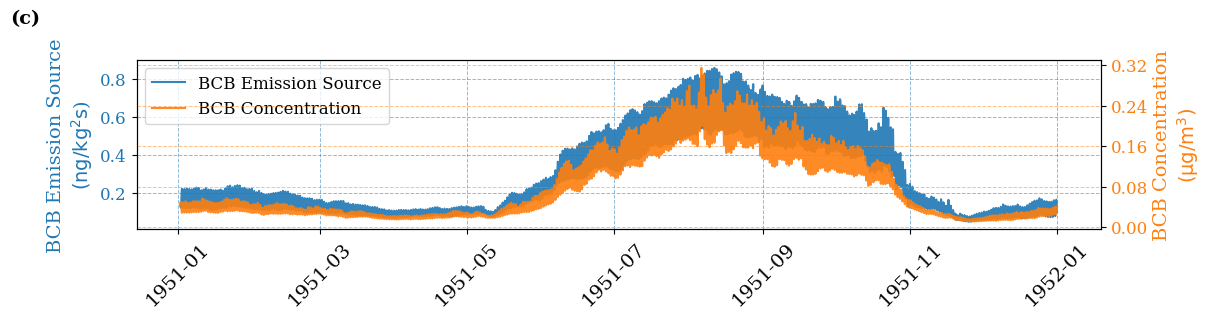

In [22]:
# Define Font style
plt.rcParams.update({'font.family': 'serif'})
from matplotlib.ticker import MaxNLocator

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 3), constrained_layout=True)

weights = np.cos(np.deg2rad(ds.lat))
weights.name = "weights"

conc = ds['Real Data'].weighted(weights).mean(dim=("lat", "lon")).values
src = ds4['BCB_biomass_src'].weighted(weights).mean(dim=("lat", "lon")).values[47:]

# Plot the first axis (src)
line1 = ax1.plot(dataset.datetimeindex, src, alpha=0.9, label='BCB Emission Source', color='tab:blue')
ax1.yaxis.set_major_locator(MaxNLocator(nbins=5))
# ax1.set_ylabel('BCB Emission Source' '\n' r'$\times 10^{-12} (\mathrm{kg} / \mathrm{kg}^{2} \mathrm{s}$)', fontsize=14, color='tab:blue')
ax1.set_ylabel('BCB Emission Source' '\n' r'$(\mathrm{ng} / \mathrm{kg}^{2} \mathrm{s}$)', fontsize=14, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.tick_params(axis='x', labelrotation=45, labelsize=14)
ax1.grid(color='tab:blue', linestyle='--', linewidth=0.7, alpha=0.5)  # Blue grid for ax1

 
# Create a second y-axis for conc
ax2 = ax1.twinx()
line2 = ax2.plot(dataset.datetimeindex, conc, alpha=0.9, label='BCB Concentration', color='tab:orange')
ax2.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax2.set_ylabel('BCB Concentration' '\n' r'$(\mathrm{\mu g} / \mathrm{m}^{\mathrm{3}})$', fontsize=14, color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')
ax2.grid(color='tab:orange', linestyle='--', linewidth=0.7, alpha=0.5)  # Orange grid for ax2

# Combine legends from both axes
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=12)

ax1.text(-0.1, 1.3, f'(c)', transform=ax1.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')

plt.show()

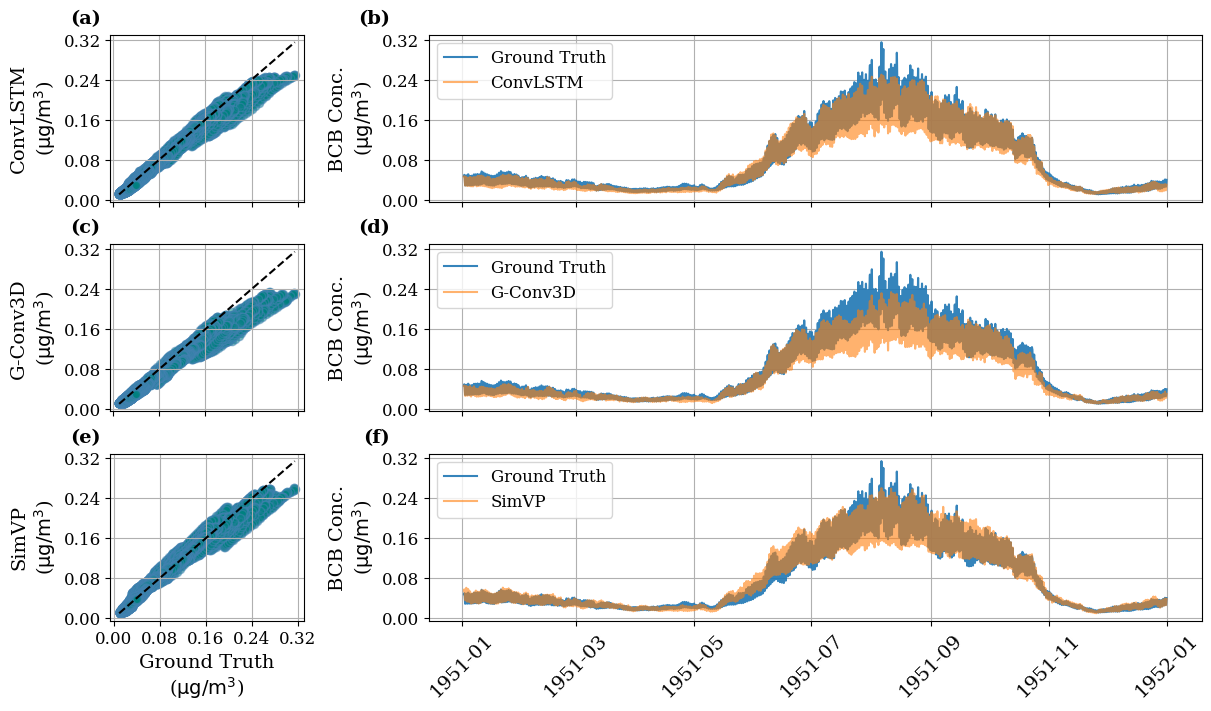

In [29]:
def plot_global_avg(ax1, ax2, ds, fig_number=('a', 'b'), model_name='ConvLSTM', xaxis=True):
    from matplotlib.ticker import MaxNLocator

    weights = np.cos(np.deg2rad(ds.lat))
    weights.name = "weights"

    ds_avg = ds.weighted(weights).mean(dim=("lat", "lon"))

    avgGT = ds_avg['Real Data'].values
    avgPD = ds_avg['Model Output'].sel(model=model_name).values

    max_value = np.array((avgGT, avgPD)).max()
    min_value = np.array((avgGT, avgPD)).min()

    ax1.scatter(avgGT.ravel(), avgPD.ravel(), color='teal', edgecolor='steelblue', alpha=0.5)
    ax1.plot([min_value, max_value], [min_value, max_value], '--', color='black', linewidth=1.5)

    ax1.yaxis.set_major_locator(mticker.MaxNLocator(nbins=5)) 
    ax1.xaxis.set_major_locator(mticker.MaxNLocator(nbins=5)) 

    # BCB mixing ratio
    ax1.set_xlabel(r'Ground Truth' '\n' r'($\mathrm{\mu g} / \mathrm{m}^{\mathrm{3}}$)', fontsize=14)
    ax1.set_ylabel(f'{model_name}' '\n' r'($\mathrm{\mu g} / \mathrm{m}^{\mathrm{3}}$)', fontsize=14)

    ax1.text(-0.05, 1.15, f'{fig_number[0]}', transform=ax1.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
    ax1.grid()

    ax2.plot(dataset.datetimeindex, avgGT, alpha=0.9, label='Ground Truth')
    ax2.plot(dataset.datetimeindex, avgPD, alpha=0.6, label=f'{model_name}')

    ax2.yaxis.set_major_locator(MaxNLocator(nbins=5)) 
    ax2.set_ylabel(r'BCB Conc.' '\n' r'($\mathrm{\mu g} / \mathrm{m}^{\mathrm{3}}$)', fontsize=14)
    ax2.tick_params(axis='x', labelrotation=45, labelsize=14)
    # ax2.set_xlim(dataset.datetimeindex[0], dataset.datetimeindex[-1])

    ax2.text(-0.05, 1.15, f'{fig_number[1]}', transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')

    if xaxis == False:
        ax1.set_xlabel('')
        ax1.tick_params(axis='x', labelbottom=False)
        ax2.tick_params(axis='x', labelbottom=False)

    ax2.legend(fontsize=12, loc='upper left')
    ax2.grid()


# Define Font style
plt.rcParams.update({'font.family': 'serif'})

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 7), constrained_layout=True, gridspec_kw={'width_ratios':[1, 4]})

plot_global_avg(axs[0, 0], axs[0, 1], ds, fig_number=('(a)', '(b)'), model_name='ConvLSTM', xaxis=False)
plot_global_avg(axs[1, 0], axs[1, 1], ds, fig_number=('(c)', '(d)'), model_name='G-Conv3D', xaxis=False)
plot_global_avg(axs[2, 0], axs[2, 1], ds, fig_number=('(e)', '(f)'), model_name='SimVP')

plt.show()

### Exceedence Probability

In [ ]:
def exceedence_probability(values):
    v = np.array(values)  # Convert to numpy array
    v = -np.sort(-v)  # Sort in descending order
    ep = 100 * np.arange(1, len(v) + 1) / (len(v) + 1)  # Weibull formula
    return v, ep


weights = np.cos(np.deg2rad(ds.lat))
weights.name = "weights"

# ds_avg = ds.weighted(weights).mean(dim=("lat", "lon"))
avgGT  = np.zeros(17473*90*144)
avgPD1 = np.zeros(17473*90*144)
avgPD2 = np.zeros(17473*90*144)
avgPD3 = np.zeros(17473*90*144)

avgGT = ds['Real Data'].values.flatten()
avgPD1 = ds['Model Output'].sel(model='ConvLSTM').values.flatten()
avgPD2 = ds['Model Output'].sel(model='G-Conv3D').values.flatten()
avgPD3 = ds['Model Output'].sel(model='SimVP').values.flatten()

v1, ep1 = exceedence_probability(avgGT)
v2, ep2 = exceedence_probability(avgPD1)
v3, ep3 = exceedence_probability(avgPD2)
v4, ep4 = exceedence_probability(avgPD3)

# In case interpolation is needed
# np.interp(0.05, weibull_exceedance_probability, sorted_flow)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)

# Plot the exceedance probabilities
ax.plot(ep1, v1, ':', alpha=1.0, label='Ground Truth')
ax.plot(ep2, v2, '-', alpha=0.9, label='ConvLSTM')
ax.plot(ep3, v3, '-', alpha=0.9, label='G-Conv3D')
ax.plot(ep4, v4, '-', alpha=0.9, label='SimVP')


# Set x-axis to logarithmic scale
ax.set_xscale('log')

# Add labels and title
ax.set_ylabel(r'BCB Concentration' '\n' r'($\mathrm{\mu g} / \mathrm{m}^{\mathrm{3}}$)', fontsize=14)
ax.set_xlabel('Exceedance Probability', fontsize=14)

# Add grid, legend, and show the plot
ax.grid(True, which="both", ls="--")
ax.legend(loc='upper right', fontsize=14)

plt.show()

In [35]:
def scatter_plot(ax, X, y, scale='linear'):

    idx = np.arange(len(X.ravel()))

    rng = np.random.default_rng(0)
    rng.shuffle(idx)

    v1 = X.ravel()[idx[:10000]]
    v2 = y.ravel()[idx[:10000]]

    max_value = np.array((v1, v2)).max()

    ax.scatter(v1, v2, color='teal', edgecolor='steelblue', alpha=0.5)
    ax.plot([0, max_value], [0, max_value], '--', color='black', linewidth=1.5)

    ax.set_xlabel('Ground Truth')
    ax.set_xscale(scale)

    ax.set_ylabel('Prediction')
    ax.set_yscale(scale)

    ax.grid()

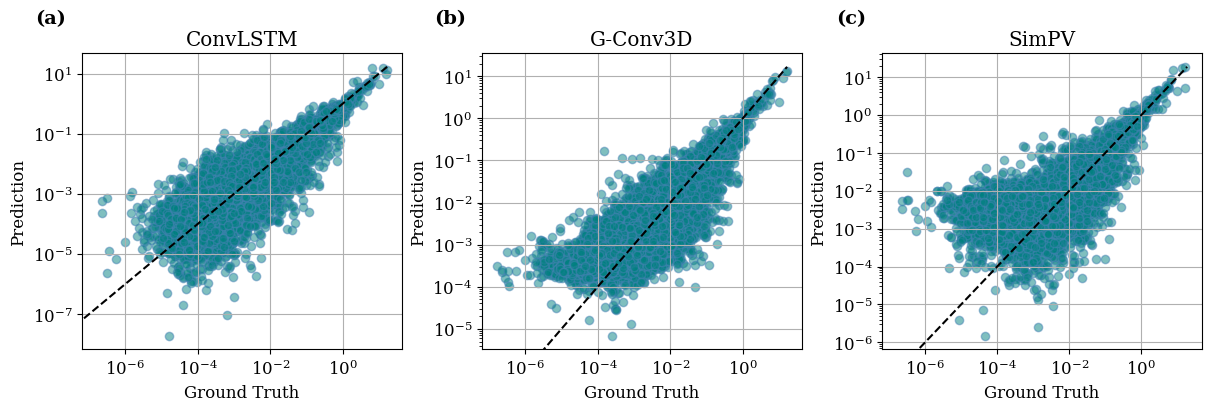

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 4), constrained_layout=True)

ax1.set_title('ConvLSTM')
scatter_plot(ax1, avgGT, avgPD1, scale='log')

ax2.set_title('G-Conv3D')
scatter_plot(ax2, avgGT, avgPD2, scale='log')

ax3.set_title('SimPV')
scatter_plot(ax3, avgGT, avgPD3, scale='log')

ax1.text(-0.05, 1.15, f'(a)', transform=ax1.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
ax2.text(-0.05, 1.15, f'(b)', transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
ax3.text(-0.05, 1.15, f'(c)', transform=ax3.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')

plt.show()

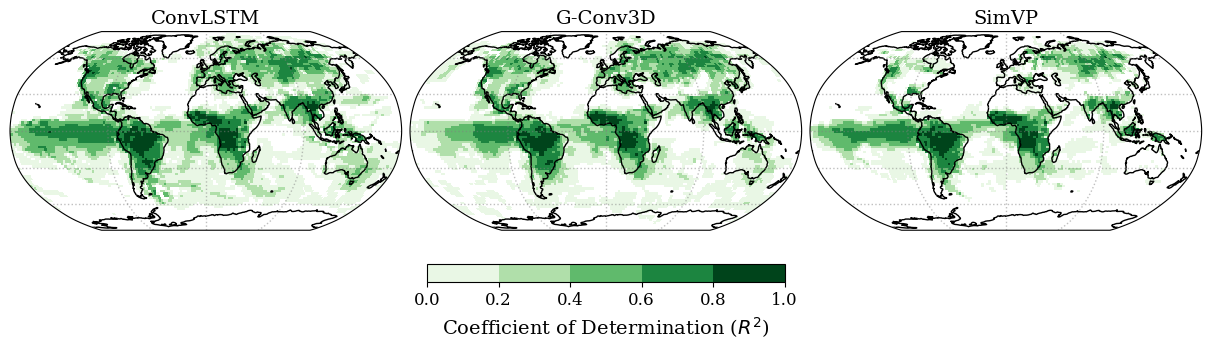

In [44]:
def plot_rsquared(ax, ds, model_name='ConvLSTM'):
    import matplotlib.colors as mcolors
    import matplotlib.ticker as mticker

    ax.coastlines()

    # Get the data for the current level
    data = ds['Coefficient of Determination'].sel(model=model_name).values
    data = np.where(data < 0, np.nan, data)  # Set negative values to NaN

    # Create a meshgrid for longitude and latitude
    lon, lat = np.meshgrid(ds['lon'], ds['lat'])

    # Define stepwise colors and corresponding boundaries
    colors = plt.cm.Greens(np.linspace(0.1, 1, 5))  # Adjust colors as needed
    bounds = np.linspace(0, 1, 6)  # Define boundaries

    # Create a colormap and normalization
    cmap = mcolors.ListedColormap(colors)
    cmap.set_bad((0.5, 0.5, 0.5, 0))  # RGBA Tuple
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Set title for the subplot
    ax.set_title(f'{model_name}', fontsize=14)

    # Plot the data using pcolormesh, which works better with projections
    im = ax.pcolormesh(
        lon, lat, data,
        transform=ccrs.PlateCarree(),
        cmap=cmap, norm=norm,
    )

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.5, linestyle=':')
    gl.xlocator = mticker.FixedLocator([-180, -90, 0, 90, 180])

    return im  # Return the image object for the colorbar

# Create the figure and subplots
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12, 4), subplot_kw={'projection': ccrs.Robinson()}, constrained_layout=True)

# Plot the data and collect the image objects
im1 = plot_rsquared(axs[0], ds, model_name='ConvLSTM')
im2 = plot_rsquared(axs[1], ds, model_name='G-Conv3D')
im3 = plot_rsquared(axs[2], ds, model_name='SimVP')

# Add a single colorbar for all subplots
cbar = fig.colorbar(im1, ax=axs, orientation='horizontal', pad=0.1, shrink=0.3)
cbar.set_label(r'Coefficient of Determination ($R^2$)', fontsize=14)
cbar.ax.tick_params(labelsize=12)  # Adjust the font size of the ticks

# axs[0].text(-0.05, 1.20, f'(a)', transform=axs[0].transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
# axs[1].text(-0.05, 1.20, f'(b)', transform=axs[1].transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
# axs[2].text(-0.05, 1.20, f'(c)', transform=axs[2].transAxes, fontsize=14, fontweight='bold', va='top', ha='right')

plt.show()

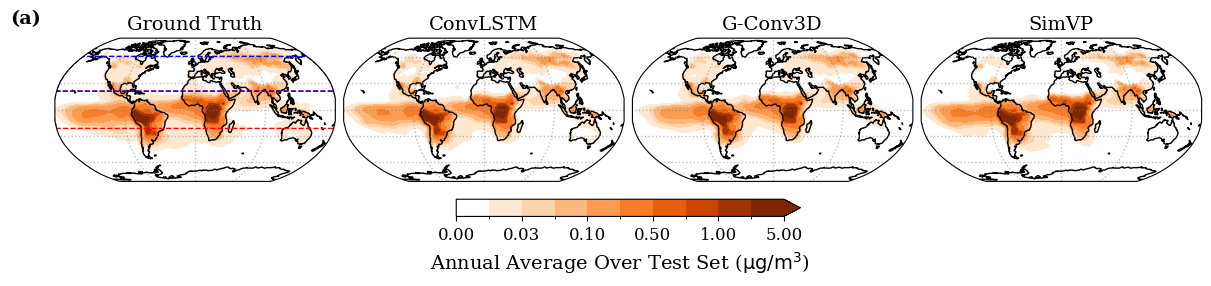

In [43]:
def plot_anual_avg_conc(ax, ds, model_name='ConvLSTM'):
    ax.coastlines()

    if model_name == 'GTs':
        ax.set_title('Ground Truth', fontsize=14)
        data = ds['Real Data'].mean(dim='time').values

        # # Create separate patches for each set of axes
        tropical_zone = patches.Rectangle((-180, -21), 360, 42, linewidth=1, edgecolor='red', facecolor='none', linestyle='--', zorder=2, transform=ccrs.PlateCarree())
        ax.add_patch(tropical_zone)

        northern_mid_latitude_zone = patches.Rectangle((-180, 21), 360, 40, linewidth=1, edgecolor='blue', facecolor='none', linestyle='--', zorder=2, transform=ccrs.PlateCarree())
        ax.add_patch(northern_mid_latitude_zone)

    else:
        ax.set_title(f'{model_name}', fontsize=14)
        data = ds['Model Output'].sel(model=model_name).mean(dim='time').values

    # Define stepwise colors and corresponding boundaries
    colors = plt.cm.Oranges(np.linspace(0, 1, 10))  # Adjust colors as needed
    colors[0] = [1, 1, 1, 1]  # Set the first color to white
    bounds = [0, 0.01, 0.03, 0.05, 0.1, 0.2, 0.5, 0.8, 1, 2, 5]

    # Create a colormap and normalization
    cmap = mcolors.ListedColormap(colors)
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Create a meshgrid for longitude and latitude
    lon, lat = np.meshgrid(ds['lon'], ds['lat'])

    im = ax.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(),
        levels=bounds, 
        cmap=cmap, norm=norm, extend='max'
    )

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.5, linestyle=':')
    gl.xlocator = mticker.FixedLocator([-180, -90, 0, 90, 180])
    gl.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60])

    return im


# Create the figure and subplots
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(12, 4), subplot_kw={'projection': ccrs.Robinson()}, constrained_layout=True)

# Plot the data and collect the image objects
im0 = plot_anual_avg_conc(axs[0], ds, model_name='GTs')
im1 = plot_anual_avg_conc(axs[1], ds, model_name='ConvLSTM')
im2 = plot_anual_avg_conc(axs[2], ds, model_name='G-Conv3D')
im3 = plot_anual_avg_conc(axs[3], ds, model_name='SimVP')

# Add a single colorbar for all subplots
cbar = fig.colorbar(im1, ax=axs, orientation='horizontal', pad=0.05, shrink=0.3)
cbar.set_label(r'Annual Average Over Test Set ($\mathrm{\mu g} / \mathrm{m}^{\mathrm{3}}$)', rotation=0, labelpad=5, fontsize=14)
cbar.ax.tick_params(labelsize=12)  # Adjust the font size of the ticks

axs[0].text(-0.05, 1.20, f'(a)', transform=axs[0].transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
# axs[1].text(-0.05, 1.20, f'(b)', transform=axs[1].transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
# axs[2].text(-0.05, 1.20, f'(c)', transform=axs[2].transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
# axs[3].text(-0.05, 1.20, f'(d)', transform=axs[3].transAxes, fontsize=14, fontweight='bold', va='top', ha='right')

plt.show()


The quantile of the value 0.01 (μg/m^3) is 66.23%


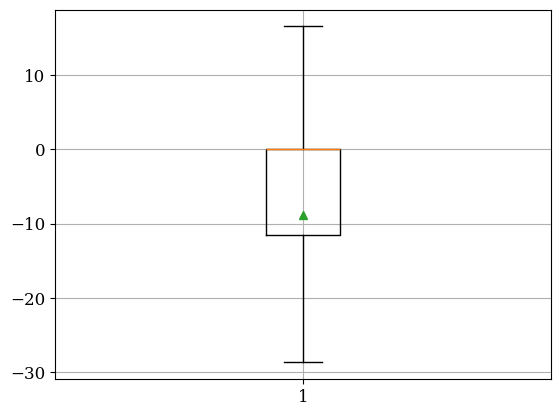

In [142]:
from scipy.stats import percentileofscore

threshold = 1E-2

# Get the data for the current level
data1 = ds['Real Data'].mean(dim='time').values
data2 = ds['Model Output'].mean(dim='time').values
data = np.where(data1 < threshold, 0, ((data2-data1)/data1) * 100)  # Set negative values to zero

# Calculate the quantile (percentile) of the given value
quantile = percentileofscore(data1.flatten(), threshold) / 100.0

print(f"The quantile of the value {threshold} (μg/m^3) is {quantile:.2%}")

plt.boxplot(data.flatten(), showmeans=True, showfliers=False)
plt.grid()
plt.show()

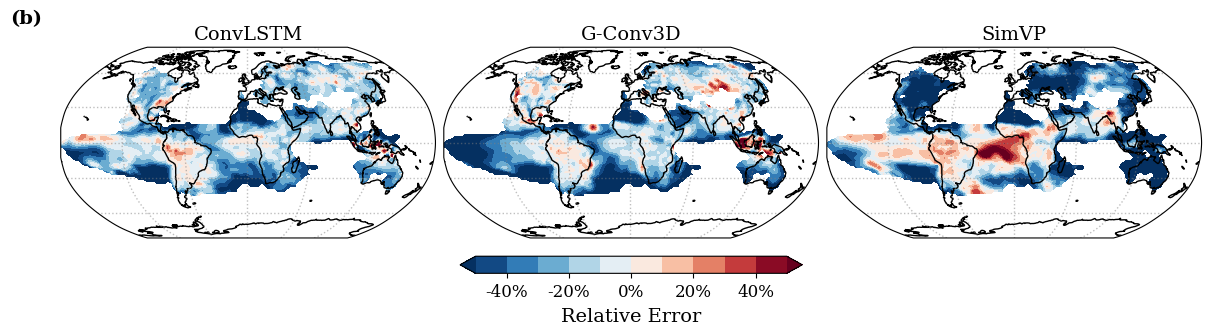

In [46]:
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_anual_avg_conc_diff(ax, ds, model_name='ConvLSTM', cmap='RdBu_r', bounds=None):
    ax.coastlines()
    ax.set_title(f'{model_name}', fontsize=14)
    
    # Get the data for the current level
    data1 = ds['Real Data'].mean(dim='time').values
    data2 = ds['Model Output'].sel(model=model_name).mean(dim='time').values
    data = np.where(data1 < 1E-2, np.nan, (data2 - data1) / data1)  # Set negative values to NaN

    # Create a meshgrid for longitude and latitude
    lon, lat = np.meshgrid(ds['lon'], ds['lat'])

    # Plot the data
    im = ax.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(),
        levels=bounds,
        cmap=cmap,
        extend='both'
    )

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.5, linestyle=':')
    gl.top_labels = False

    # Set font size for gridline labels
    gl.xlabel_style = {'size': 4}
    gl.ylabel_style = {'size': 4}

    return im  # Return the image object for the colorbar

# Define the colormap and bounds
bounds = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
cmap = 'RdBu_r'

# Create the figure and subplots
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12, 4), subplot_kw={'projection': ccrs.Robinson()}, constrained_layout=True)

# Plot the data and collect the image objects
im1 = plot_anual_avg_conc_diff(axs[0], ds, model_name='ConvLSTM', cmap=cmap, bounds=bounds)
im2 = plot_anual_avg_conc_diff(axs[1], ds, model_name='G-Conv3D', cmap=cmap, bounds=bounds)
im3 = plot_anual_avg_conc_diff(axs[2], ds, model_name='SimVP', cmap=cmap, bounds=bounds)

# Add a single colorbar for all subplots
cbar = fig.colorbar(im1, ax=axs, orientation='horizontal', pad=0.05, shrink=0.3)
cbar.set_label('Relative Error', rotation=0, labelpad=5, fontsize=14)
cbar.ax.tick_params(labelsize=12)
# cbar.set_ticks(bounds)
cbar.ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.0%}'))

axs[0].text(-0.05, 1.20, f'(b)', transform=axs[0].transAxes, fontsize=14, fontweight='bold', va='top', ha='right')

plt.show()

In [19]:
from matplotlib.ticker import FormatStrFormatter

# roi = 'Northern Mid-Latitude Zone'
roi = 'Tropical Zone'

def regional_plot(ax1, ax2, ds, roi='Northern Mid-Latitude Zone', fig_numbers=('(a)', '(b)'), xaxis=True):

    if roi == 'Northern Mid-Latitude Zone':
        ds_roi = ds.mean(dim=("time")).sel(lat=slice(21, 61))

    elif roi == 'Tropical Zone':
        ds_roi = ds.mean(dim=("time")).sel(lat=slice(-21, 21))

    weights = np.cos(np.deg2rad(ds_roi.lat))
    weights.name = "weights"

    avgGT = ds_roi['Real Data'].weighted(weights).mean(dim=("lat"))
    avgPD1 = ds_roi['Model Output'].sel(model='ConvLSTM').weighted(weights).mean(dim=("lat"))
    avgPD2 = ds_roi['Model Output'].sel(model='Conv3D').weighted(weights).mean(dim=("lat"))
    avgPD3 = ds_roi['Model Output'].sel(model='SimVP').weighted(weights).mean(dim=("lat"))

    max_value = np.array((avgGT, avgPD1, avgPD2, avgPD3)).max()
    min_value = np.array((avgGT, avgPD1, avgPD2, avgPD3)).min()

    ax1.scatter(avgGT.values, avgPD1.values, color='b', edgecolor='b', alpha=0.8, label='ConvLSTM')
    ax1.scatter(avgGT.values, avgPD2.values, color='r', edgecolor='r', alpha=0.6, label='G-Conv3D')
    ax1.scatter(avgGT.values, avgPD3.values, color='g', edgecolor='g', alpha=0.4, label='SimVP')

    ax1.plot([min_value, max_value], [min_value, max_value], '--', color='black', linewidth=1.5)

    ax1.set_xlabel(r'Ground Truth' '\n' r'$\mathrm{\mu g} / \mathrm{m}^{\mathrm{3}}$', fontsize=14)
    ax1.set_ylabel(r'ML Prediction' '\n' r'$\mathrm{\mu g} / \mathrm{m}^{\mathrm{3}}$', fontsize=14)

    ax1.yaxis.set_major_locator(mticker.MaxNLocator(nbins=5))
    ax1.xaxis.set_major_locator(mticker.MaxNLocator(nbins=5))

    ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    ax1.legend(fontsize=12, loc='upper left', frameon=True, framealpha=0.2) 
    ax1.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

    avgGT.plot(ax=ax2, label='Ground Truth', color='black', linestyle='-', linewidth=1)
    avgPD1.plot(ax=ax2, label='ConvLSTM', color='b', linestyle='--', linewidth=1)
    avgPD2.plot(ax=ax2, label='G-Conv3D', color='r', linestyle='--', linewidth=1)
    avgPD3.plot(ax=ax2, label='SimVP', color='g', linestyle='--', linewidth=1)

    ax2.set_xlabel('Longitude', fontsize=14)
    ax2.set_ylabel(' ')
    ax2.set_title('')

    ax2.yaxis.set_major_locator(mticker.MaxNLocator(nbins=5))
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    ax2.legend(fontsize=12, loc='upper left', frameon=True, framealpha=0.2) 
    ax2.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

    ax1.text(-0.05, 1.15, f'{fig_numbers[0]}', transform=ax1.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
    ax2.text(-0.05, 1.15, f'{fig_numbers[1]}', transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')

    if xaxis == False:
        ax1.set_xlabel('')
        # ax1.tick_params(axis='x', labelbottom=False)

        ax2.set_xlabel('')
        # ax2.tick_params(axis='x', labelbottom=False)

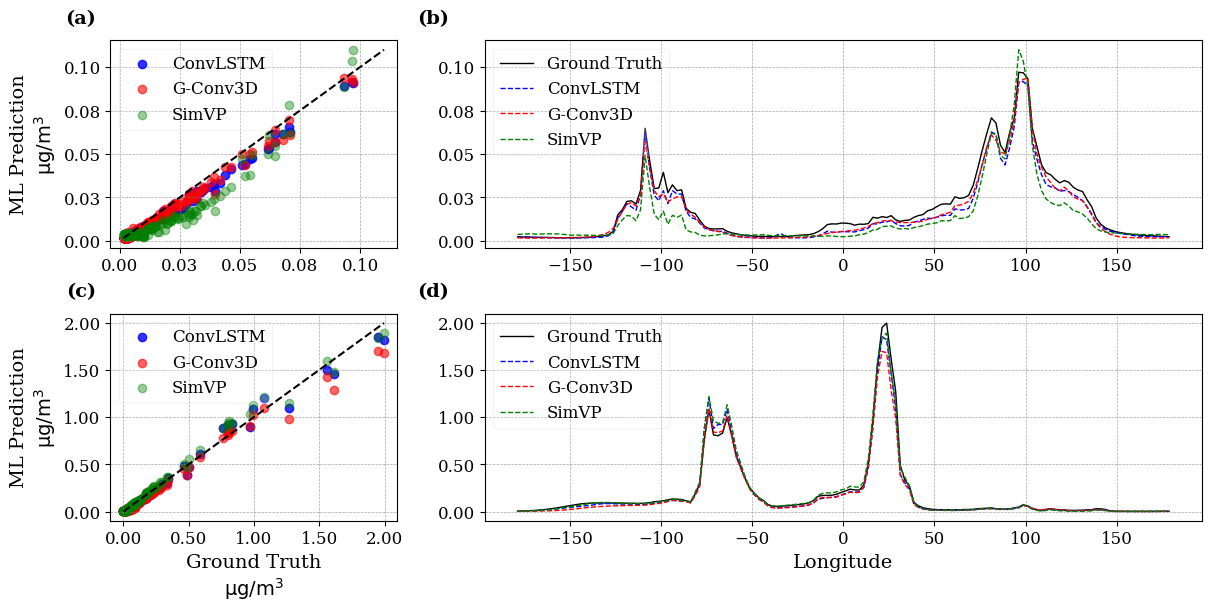

In [20]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 6), constrained_layout=True, gridspec_kw={'width_ratios':[2, 5]})

regional_plot(axs[0, 0], axs[0, 1], ds, roi='Northern Mid-Latitude Zone', xaxis=False)
regional_plot(axs[1, 0], axs[1, 1], ds, roi='Tropical Zone', fig_numbers=('(c)', '(d)'))

plt.show()